# Khi-2 Test applied to varying mixing weights models 

Margaux Thorez

## 1- Contextualization

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.stats import norm

#Khi 2 Test
from scipy.stats import chisquare

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_notebook_menu()

## 3- Base model - optimized functions

### Survival functions

In [3]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [4]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [5]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [6]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [7]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [8]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [9]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 ou 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [10]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [11]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- First analysis

For now, the analysis is only made for Ryzhov's model. 

In [12]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 30

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

In [13]:
#Ryzhov :
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [14]:
#Probability calculation a posteriori
if law == "exponnential":
    #For group 1
    P1_0 = stats.expon.cdf(7, loc=0, scale=lambd1) # "<7 days"
    P1_1 = stats.expon.cdf(14, loc=0, scale=lambd1) - stats.expon.cdf(7, loc=0, scale=lambd1)  # "8-14 days"
    P1_2 = stats.expon.cdf(30, loc=0, scale=lambd1) - stats.expon.cdf(14, loc=0, scale=lambd1)  # "15-30 days"
    P1_3 = stats.expon.cdf(60, loc=0, scale=lambd1) - stats.expon.cdf(30, loc=0, scale=lambd1)  # "31-60 days"
    P1_4 = stats.expon.cdf(90, loc=0, scale=lambd1) - stats.expon.cdf(60, loc=0, scale=lambd1)  # "61-90 days"
    P1_5 = stats.expon.cdf(120, loc=0, scale=lambd1) - stats.expon.cdf(90, loc=0, scale=lambd1)  # "91-120 days"
    P1_6 = 1 -  stats.expon.cdf(120, loc=0, scale=lambd1)   # ">120 days"
    #For group 2
    P2_0 = stats.expon.cdf(7, loc=0, scale=lambd2) # "<7 days"
    P2_1 = stats.expon.cdf(14, loc=0, scale=lambd2) - stats.expon.cdf(7, loc=0, scale=lambd2)  # "8-14 days"
    P2_2 = stats.expon.cdf(30, loc=0, scale=lambd2) - stats.expon.cdf(14, loc=0, scale=lambd2)  # "15-30 days"
    P2_3 = stats.expon.cdf(60, loc=0, scale=lambd2) - stats.expon.cdf(30, loc=0, scale=lambd2)  # "31-60 days"
    P2_4 = stats.expon.cdf(90, loc=0, scale=lambd2) - stats.expon.cdf(60, loc=0, scale=lambd2)  # "61-90 days"
    P2_5 = stats.expon.cdf(120, loc=0, scale=lambd2) - stats.expon.cdf(90, loc=0, scale=lambd2)  # "91-120 days"
    P2_6 = 1 - stats.expon.cdf(120, loc=0, scale=lambd2)   # ">120 days"
if law == "pareto":
    #For group 1
    P1_0 = stats.expon.cdf(7, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1) # "<7 days"
    P1_1 = stats.expon.cdf(14, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)- stats.expon.cdf(7, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)   # "8-14 days"
    P1_2 = stats.expon.cdf(30, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1) - stats.expon.cdf(14, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)  # "15-30 days"
    P1_3 = stats.expon.cdf(60, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)  - stats.expon.cdf(30, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)   # "31-60 days"
    P1_4 = stats.expon.cdf(90, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)  - stats.expon.cdf(60, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)   # "61-90 days"
    P1_5 = stats.expon.cdf(120, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)  - stats.expon.cdf(90, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)   # "91-120 days"
    P1_6 = 1 -  stats.expon.cdf(120, b=3, loc=-(2/3)*lambd1, scale=(2/3)*lambd1)   # ">120 days"
    #For group 2
    P2_0 = stats.expon.cdf(7, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)  # "<7 days"
    P2_1 = stats.expon.cdf(14, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2) - stats.expon.cdf(7, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)  # "8-14 days"
    P2_2 = stats.expon.cdf(30, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2) - stats.expon.cdf(14, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2) # "15-30 days"
    P2_3 = stats.expon.cdf(60, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)- stats.expon.cdf(30, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)  # "31-60 days"
    P2_4 = stats.expon.cdf(90, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2) - stats.expon.cdf(60, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)  # "61-90 days"
    P2_5 = stats.expon.cdf(120, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2) - stats.expon.cdf(90, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)  # "91-120 days"
    P2_6 = 1 - stats.expon.cdf(120, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)   # ">120 days"
if law == "weibull":
    #For group 1
    P1_0 = stats.weibull_min.cdf(7, c=2, scale=lambd1) # "<7 days"
    P1_1 = stats.weibull_min.cdf(14, c=2, scale=lambd1) - stats.weibull_min.cdf(7, c=2, scale=lambd1)  # "8-14 days"
    P1_2 = stats.weibull_min.cdf(30, c=2, scale=lambd1) - stats.weibull_min.cdf(14, c=2, scale=lambd1)  # "15-30 days"
    P1_3 = stats.weibull_min.cdf(60, c=2, scale=lambd1) - stats.weibull_min.cdf(30, c=2, scale=lambd1)  # "31-60 days"
    P1_4 = stats.weibull_min.cdf(90, c=2, scale=lambd1) - stats.weibull_min.cdf(60, c=2, scale=lambd1)  # "61-90 days"
    P1_5 = stats.weibull_min.cdf(120, c=2, scale=lambd1) - stats.weibull_min.cdf(90, c=2, scale=lambd1)  # "91-120 days"
    P1_6 = 1 -  stats.weibull_min.cdf(120, c=2, scale=lambd1)   # ">120 days"
    #For group 2
    P2_0 = stats.weibull_min.cdf(7, c=2, scale=lambd2) # "<7 days"
    P2_1 = stats.weibull_min.cdf(14, c=2, scale=lambd2) - stats.weibull_min.cdf(7, c=2, scale=lambd2)  # "8-14 days"
    P2_2 = stats.weibull_min.cdf(30, c=2, scale=lambd2) - stats.weibull_min.cdf(14, c=2, scale=lambd2)  # "15-30 days"
    P2_3 = stats.weibull_min.cdf(60, c=2, scale=lambd2) - stats.weibull_min.cdf(30, c=2, scale=lambd2)  # "31-60 days"
    P2_4 = stats.weibull_min.cdf(90, c=2, scale=lambd2) - stats.weibull_min.cdf(60, c=2, scale=lambd2)  # "61-90 days"
    P2_5 = stats.weibull_min.cdf(120, c=2, scale=lambd2) - stats.weibull_min.cdf(90, c=2, scale=lambd2)  # "91-120 days"
    P2_6 = 1 - stats.weibull_min.cdf(120, c=2, scale=lambd2)   # ">120 days"
if law == "gamma":
    #For group 1
    P1_0 = stats.gamma.cdf(7, loc=0, scale=lambd1) # "<7 days"
    P1_1 = stats.gamma.cdf(14, loc=0, scale=lambd1) - stats.gamma.cdf(7, loc=0, scale=lambd1)  # "8-14 days"
    P1_2 = stats.gamma.cdf(30, loc=0, scale=lambd1) - stats.gamma.cdf(14, loc=0, scale=lambd1)  # "15-30 days"
    P1_3 = stats.gamma.cdf(60, loc=0, scale=lambd1) - stats.gamma.cdf(30, loc=0, scale=lambd1)  # "31-60 days"
    P1_4 = stats.gamma.cdf(90, loc=0, scale=lambd1) - stats.gamma.cdf(60, loc=0, scale=lambd1)  # "61-90 days"
    P1_5 = stats.gamma.cdf(120, loc=0, scale=lambd1) - stats.gamma.cdf(90, loc=0, scale=lambd1)  # "91-120 days"
    P1_6 = 1 -  stats.gamma.cdf(120, loc=0, scale=lambd1)   # ">120 days"
    #For group 2
    P2_0 = stats.gamma.cdf(7, loc=0, scale=lambd2) # "<7 days"
    P2_1 = stats.gamma.cdf(14, loc=0, scale=lambd2) - stats.gamma.cdf(7, loc=0, scale=lambd2)  # "8-14 days"
    P2_2 = stats.gamma.cdf(30, loc=0, scale=lambd2) - stats.gamma.cdf(14, loc=0, scale=lambd2)  # "15-30 days"
    P2_3 = stats.gamma.cdf(60, loc=0, scale=lambd2) - stats.gamma.cdf(30, loc=0, scale=lambd2)  # "31-60 days"
    P2_4 = stats.gamma.cdf(90, loc=0, scale=lambd2) - stats.gamma.cdf(60, loc=0, scale=lambd2)  # "61-90 days"
    P2_5 = stats.gamma.cdf(120, loc=0, scale=lambd2) - stats.gamma.cdf(90, loc=0, scale=lambd2)  # "91-120 days"
    P2_6 = 1 - stats.gamma.cdf(120, loc=0, scale=lambd2)   # ">120 days"

In [15]:
f_exp_A = np.array([P_A1*P1_0+P_A2*P2_0, P_A1*P1_1+P_A2*P2_1, P_A1*P1_2+P_A2*P2_2, P_A1*P1_3+P_A2*P2_3, P_A1*P1_4+P_A2*P2_4, P_A1*P1_5+P_A2*P2_5, P_A1*P1_6+P_A2*P2_6])
f_exp_A

array([0.15388237, 0.12894229, 0.22264337, 0.24309544, 0.12079119,
       0.06164808, 0.06899726])

In [16]:
f_exp_B = np.array([P_B1*P1_0+P_B2*P2_0, P_B1*P1_1+P_B2*P2_1, P_B1*P1_2+P_B2*P2_2, P_B1*P1_3+P_B2*P2_3, P_B1*P1_4+P_B2*P2_4, P_B1*P1_5+P_B2*P2_5, P_B1*P1_6+P_B2*P2_6])
f_exp_B

array([0.20036357, 0.15967788, 0.25398589, 0.23405148, 0.09058293,
       0.03578238, 0.02555587])

In [17]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]
    
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
       
    return (time_A, time_B)

In [18]:
time_A, time_B = RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction)

In [19]:
df_obs_A = pd.DataFrame(time_A, columns=["Duration"])
df_obs_B = pd.DataFrame(time_B, columns=["Duration"])

In [20]:
#Breakdown of sick leaves by duration
df_duree = df_obs_A
df_duree["Duration group"] = 0
for i in range(len(df_duree)):
    if df_duree["Duration"][i]>120:
        df_duree["Duration group"][i] = ">120 days"
    if df_duree["Duration"][i]<=120:
        df_duree["Duration group"][i] = "91-120 days"
    if df_duree["Duration"][i]<=90:
        df_duree["Duration group"][i] = "61-90 days"
    if df_duree["Duration"][i]<=60:
        df_duree["Duration group"][i] = "31-60 days"
    if df_duree["Duration"][i]<=30:
        df_duree["Duration group"][i] = "15-30 days"
    if df_duree["Duration"][i]<=14:
        df_duree["Duration group"][i] = "8-14 days"
    if df_duree["Duration"][i]<=7:
        df_duree["Duration group"][i] = "≤7 days"
df_obs2_A = df_duree

#Breakdown of sick leaves by duration
df_duree = df_obs_B
df_duree["Duration group"] = 0
for i in range(len(df_duree)):
    if df_duree["Duration"][i]>120:
        df_duree["Duration group"][i] = ">120 days"
    if df_duree["Duration"][i]<=120:
        df_duree["Duration group"][i] = "91-120 days"
    if df_duree["Duration"][i]<=90:
        df_duree["Duration group"][i] = "61-90 days"
    if df_duree["Duration"][i]<=60:
        df_duree["Duration group"][i] = "31-60 days"
    if df_duree["Duration"][i]<=30:
        df_duree["Duration group"][i] = "15-30 days"
    if df_duree["Duration"][i]<=14:
        df_duree["Duration group"][i] = "8-14 days"
    if df_duree["Duration"][i]<=7:
        df_duree["Duration group"][i] = "≤7 days"
df_obs2_B = df_duree

In [21]:
BA = df_obs2_A.groupby(['Duration group'])['Duration'].count()
BB = df_obs2_B.groupby(['Duration group'])['Duration'].count()

In [22]:
BA

Duration group
15-30 days     1164
31-60 days     1189
61-90 days      616
8-14 days       622
91-120 days     306
>120 days       345
≤7 days         758
Name: Duration, dtype: int64

In [23]:
f_obs_A = np.array([BA["≤7 days"], BA["8-14 days"], BA["15-30 days"], BA["31-60 days"], BA["61-90 days"], BA["91-120 days"], BA[">120 days"]])
f_obs_B = np.array([BB["≤7 days"], BB["8-14 days"], BB["15-30 days"], BB["31-60 days"], BB["61-90 days"], BB["91-120 days"], BB[">120 days"]])

In [24]:
df_duree_bis = df_obs2_A.groupby(["Duration group"], as_index=True)[["Duration"]].count()
df_duree_bis = df_duree_bis.loc[["≤7 days", "8-14 days", '15-30 days','31-60 days','61-90 days','91-120 days','>120 days']]
total = sum(df_duree_bis["Duration"])
df_duree_bis["Prop"] = df_duree_bis["Duration"]/total
df_duree_bis["Total"] = df_duree_bis["Prop"]
for k in range(len(df_duree_bis.index)-1):
    j = df_duree_bis.index[k]
    i = df_duree_bis.index[k+1]
    df_duree_bis["Total"][i] = df_duree_bis["Total"][i] + df_duree_bis["Total"][j]

Text(0.5, 1.0, 'Distribution of sick leaves durations')

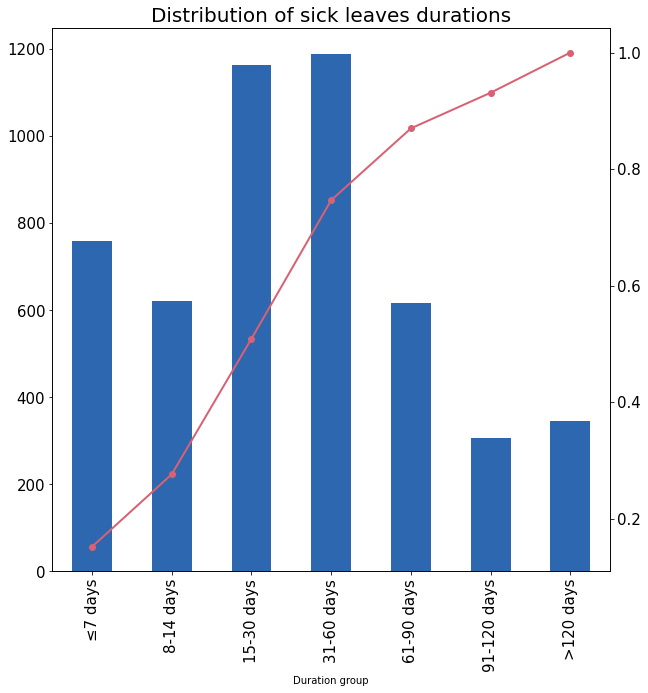

In [25]:
fig, ax = plt.subplots(figsize=(15, 15)) 
g=df_duree_bis.iloc[:,0].plot(kind='bar', stacked=True,  figsize=(10,10),color='#2C67AF')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax2 = plt.gca().twinx()
df_duree_bis.iloc[:,2].plot(kind='line',   use_index=True, linestyle='solid', lw=2, marker='o',color='#D86173')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_title("Distribution of sick leaves durations", fontsize = 20)

In [26]:
chisquare(f_obs=f_obs_A, f_exp=nA*f_exp_A)

Power_divergenceResult(statistic=4.119198716934823, pvalue=0.6605493280559367)

In [27]:
chisquare(f_obs=f_obs_B, f_exp=nB*f_exp_B)

Power_divergenceResult(statistic=2.443481833526205, pvalue=0.8747385507811434)

In [28]:
T = 0 
for k in range(len(f_obs_A)):
    T += (f_obs_A[k] - nA*f_exp_A[k])**2/(nA*f_exp_A[k]) + (f_obs_B[k] - nB*f_exp_B[k])**2/(nB*f_exp_B[k])
T

6.562680550461027

## 5- Khi-2 Test without censorship 

In [29]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]
    
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    
    #Observed durations
    df_obs_A = pd.DataFrame(time_A, columns=["Duration"])
    df_obs_B = pd.DataFrame(time_B, columns=["Duration"])
    
    #Breakdown of sick leaves by duration
    df_duree = df_obs_A
    df_duree["Duration group"] = 0
    for i in range(len(df_duree)):
        if df_duree["Duration"][i]>120:
            df_duree["Duration group"][i] = ">120 days"
        if df_duree["Duration"][i]<=120:
            df_duree["Duration group"][i] = "91-120 days"
        if df_duree["Duration"][i]<=90:
            df_duree["Duration group"][i] = "61-90 days"
        if df_duree["Duration"][i]<=60:
            df_duree["Duration group"][i] = "31-60 days"
        if df_duree["Duration"][i]<=30:
            df_duree["Duration group"][i] = "15-30 days"
        if df_duree["Duration"][i]<=14:
            df_duree["Duration group"][i] = "8-14 days"
        if df_duree["Duration"][i]<=7:
            df_duree["Duration group"][i] = "≤7 days"
    df_obs2_A = df_duree

    #Breakdown of sick leaves by duration
    df_duree = df_obs_B
    df_duree["Duration group"] = 0
    for i in range(len(df_duree)):
        if df_duree["Duration"][i]>120:
            df_duree["Duration group"][i] = ">120 days"
        if df_duree["Duration"][i]<=120:
            df_duree["Duration group"][i] = "91-120 days"
        if df_duree["Duration"][i]<=90:
            df_duree["Duration group"][i] = "61-90 days"
        if df_duree["Duration"][i]<=60:
            df_duree["Duration group"][i] = "31-60 days"
        if df_duree["Duration"][i]<=30:
            df_duree["Duration group"][i] = "15-30 days"
        if df_duree["Duration"][i]<=14:
            df_duree["Duration group"][i] = "8-14 days"
        if df_duree["Duration"][i]<=7:
            df_duree["Duration group"][i] = "≤7 days"
    df_obs2_B = df_duree    
    
    BA = df_obs2_A.groupby(['Duration group'])['Duration'].count()
    BB = df_obs2_B.groupby(['Duration group'])['Duration'].count()
    
    f_obs_A = np.array([BA["≤7 days"], BA["8-14 days"], BA["15-30 days"], BA["31-60 days"], BA["61-90 days"], BA["91-120 days"], BA[">120 days"]])
    f_obs_B = np.array([BB["≤7 days"], BB["8-14 days"], BB["15-30 days"], BB["31-60 days"], BB["61-90 days"], BB["91-120 days"], BB[">120 days"]])
    
    #Khi 2 Test
    T_A = 0 
    T_B = 0
    for k in range(len(f_obs_A)):
        T_A += (f_obs_A[k] - nA*f_exp_A[k])**2/(nA*f_exp_A[k])
        T_B += (f_obs_B[k] - nB*f_exp_B[k])**2/(nB*f_exp_B[k])
    T = T_A + T_B
       
    return (T)

In [30]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, direction = direction) for k in range(K)])

    #Concatenation into array
    List_T = np.array([T for T    in ComputedBlocks], dtype=np.dtype(object)) 
   
    #return ComputedBlocks
    return List_T

#### Parameters choice

In [31]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 30

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


In [32]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


#### Results of one simulation

In [33]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction)

9.622314287917447

#### Results of K simulations

In [34]:
#Number of repetitions
K = 1000

In [35]:
List_T = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [36]:
T = List_T.tolist()

In [38]:
df = 12

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $T$')

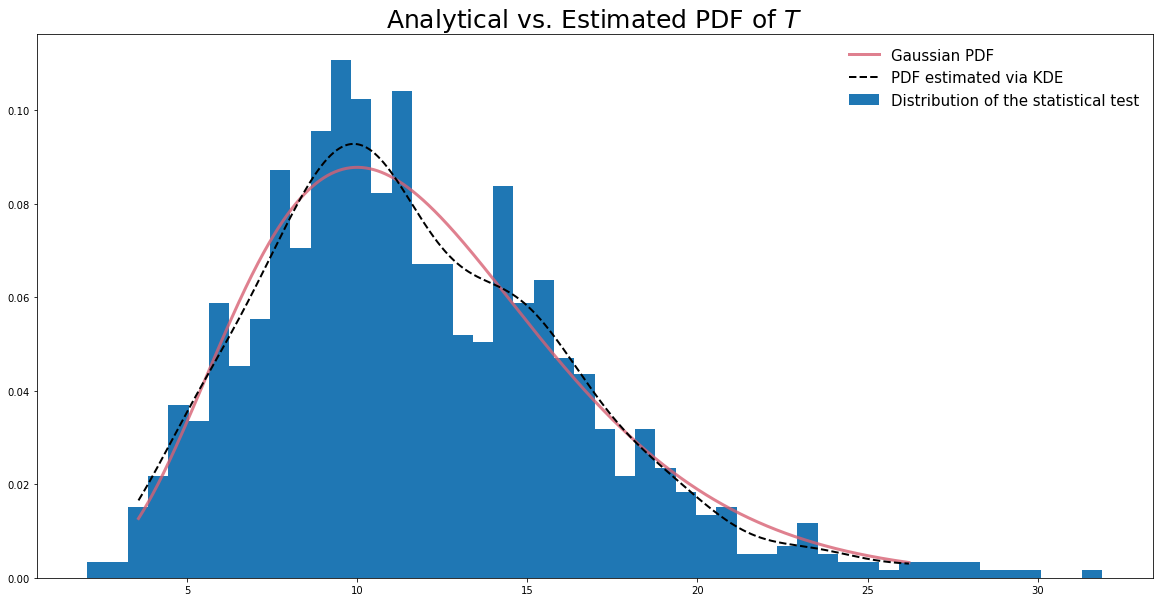

In [39]:
#Graphical representation of the distribution
dist = stats.chi2(df=df)
x = np.linspace(start=stats.chi2.ppf(0.01, df), stop=stats.chi2.ppf(0.99, df), num=K)
gkde = stats.gaussian_kde(dataset=T)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(T,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $T$', fontsize = 25)